In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm
import pandas as pd

## Differential gene expression analysis

### Plan

#### DGE
- calculate differential expressed genes for each cell type and visualize them using a large grid to showcase the plotting functionalities
- annotate the tumor buds
- compare tumor buds vs non-tumor buds using differential gene expression analysis + GO term analysis
    - identify genes that are different across all samples
        - GO term enrichment analysis or similar way to check out these genes (StringDB gene network?)
    - This could be also a pseudobulk case: tumor bud vs bulk tumor using all samples as replicate?
- and visualize the tumor bud cells on UMAP to see their location

#### Cancer subtyping
- Subcluster cancer cell cluster and show cellular composition of Tumor vs tumor bud


#### Pseudobulk
- generate a pseudobulk version of the data and visualize it as heatmap


In [3]:
data_path = Path(r"E:\ColorectalCancer\analysis\proseg_only")

In [4]:
exp = InSituExperiment.read(data_path)
exp.load_all()

100%|██████████| 7/7 [00:34<00:00,  4.98s/it]


In [5]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id       sample_id  Region  ...  Metastasis type     H number              HE           panCK annotations_Tanja
0     3d377351  ++++-      3621  Region_1-14...       1  ...             NaN   1414/18 IIA  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
1     039bf1f8  ++++-      3621  Region_2-14...       2  ...     synchronous   1414/18 IIS  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
2     1c928862  ++++-      3621  Region_3-33...       3  ...    asynchronous   3311/18 IVA  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
3     18755ab6  ++++-      3621  Region_4-14...       4  ...     synchronous    1414/18 IC  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
4     3ee0776f  ++++-      3991  Region_1-53...       1  ...             NaN   5316/18 IVC  C:\Users\ge...  C:\Users\ge...  E:\Colorect...  
5     4e08eb69  ++++-      3991  Region_2-53...       2  ...     synchronous   5316/18 IVS  C:\Users\ge...  C:\Users\ge..

In [6]:
exp.metadata

,uid,slide_id,sample_id,Region,Patient,Tissue,Type,Sample Name,Metastasis type,H number,HE,panCK,annotations_Tanja
0,3d377351,3621,Region_1-1414_18_IIA,1,1,Colon,primary tumor,Colorectal Cancer,NaN,1414/18 IIA,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
1,039bf1f8,3621,Region_2-1414_18_IIS,2,1,Lymph node,metastasis,Lymph node metastasis,synchronous,1414/18 IIS,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
2,1c928862,3621,Region_3-3311_18_IVA,3,1,Lung,metastasis,Lung metastasis,asynchronous,3311/18 IVA,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
3,18755ab6,3621,Region_4-1414_18_IC,4,1,Liver,metastasis,Liver metastasis,synchronous,1414/18 IC,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
4,3ee0776f,3991,Region_1-5316_18_IVC,1,2,Colon,primary tumor,Colorectal Cancer,NaN,5316/18 IVC,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
5,4e08eb69,3991,Region_2-5316_18_IV,2,2,Lymph node,metastasis,Lymph node metastasis,synchronous,5316/18 IVS,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...
6,c20dbd1b,3991,Region_3-1367_19_A,3,2,Lung,metastasis,Lung metastasis,asynchronous,1367/19 A,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,C:\Users\ge37voy\OneDrive - TUM\Dokumente - Sp...,E:\ColorectalCancer\annotations_Tanja\exports\...


In [7]:
from insitupy.plotting import plot_overview

Saving figure to file figures/exp_overview_new.pdf
Saved.


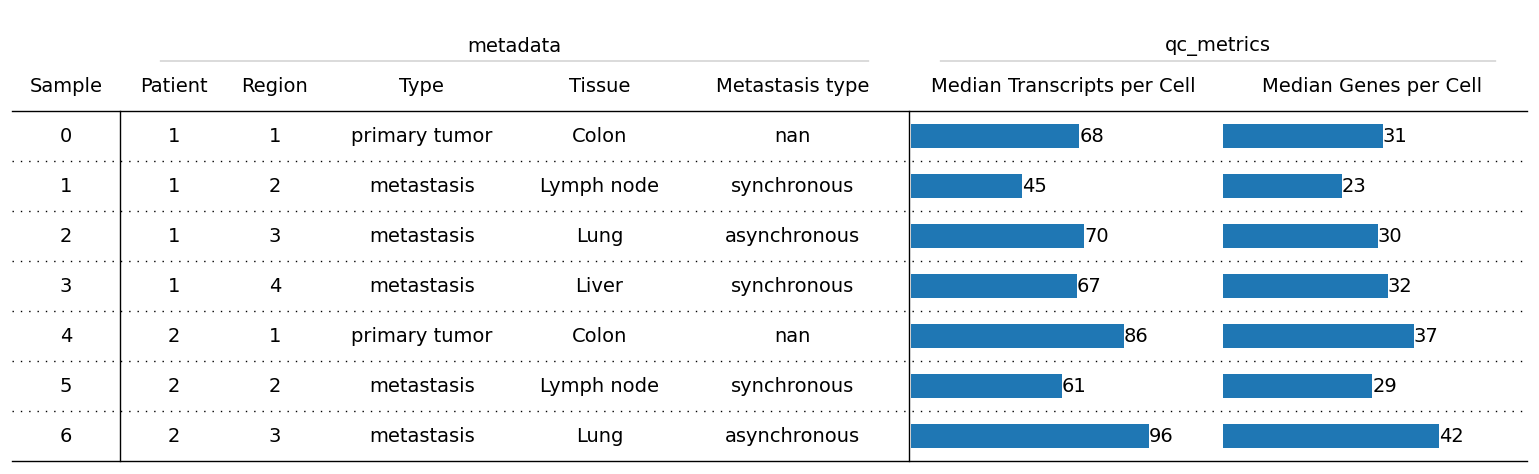

In [8]:
plot_overview(
    exp,
    cells_layer="proseg",
    columns_to_plot=["Patient", "Region", "Type", "Tissue", "Metastasis type"],
    savepath="figures/exp_overview_new.pdf"
    )

### Import new annotations

The annotations have changed a bit in the meantime. Here we reload the new annotations from QuPath.

In [8]:
exp.append_metadata(
    new_metadata=r"E:\ColorectalCancer\annotations_Tanja\exports\import_annotations_config.xlsx",
    by="sample_id", overwrite=True
)

In [9]:
for meta, xd in exp.iterdata():
    # remove data from key
    xd.annotations.remove_key("Tanja")

    # import new annotations
    p = meta["annotations_Tanja"]
    xd.import_annotations(
        files=p, keys="Tanja", scale_factor=0.2125
)

Show overview of annotations.

In [10]:
exp.annotations

0: Region_1-1414_18_IIA
       Tanja:	119 annotations, 6 classes ('Fat', 'Immune cells', 'Mucus', 'Peritumoral Zone', 'Tumor', 'Tumor buds') 
1: Region_2-1414_18_IIS
       Tanja:	169 annotations, 5 classes ('Fat', 'Immune cells', 'Peritumoral Zone', 'Tumor', 'Tumor buds') 
2: Region_3-3311_18_IVA
       Tanja:	97 annotations, 4 classes ('Invasive tumor', 'Peritumoral Zone', 'Tumor', 'Tumor buds') 
3: Region_4-1414_18_IC
       Tanja:	165 annotations, 6 classes ('Immune cells', 'Mucus', 'Necrosis', 'Peritumoral Zone', 'Tumor', 'Tumor buds') 
4: Region_1-5316_18_IVC
       Tanja:	380 annotations, 8 classes ('Fat', 'Immune cells', 'Necrosis', 'Peritumoral Zone', 'Stroma', 'Tumor', 'Tumor buds', 'Vessels') 
5: Region_2-5316_18_IV
       Tanja:	31 annotations, 4 classes ('Immune cells', 'Peritumoral Zone', 'Tumor', 'Tumor buds') 
6: Region_3-1367_19_A
       Tanja:	79 annotations, 8 classes ('Adjacent normal tissue', 'Immune cells', 'Necrosis', 'Peritumoral Zone', 'Stroma', 'Tumor', 'Tumor

Save with lower resolution on computer.

In [11]:
# path for downscaled data
ds_path = r"C:\Data\CRC\crc_data_pp_rounded_all_images_ds"
try:
    exp.saveas(
        path=ds_path,
        images_max_resolution=2
        )
except FileExistsError:
    print("File already exists, skipped saving.")

File already exists, skipped saving.


Fix the colors of the cell type columns by adding a "{}_colors" key to `.uns` using the `.sync_colors` function.

In [12]:
exp.sync_colors(
    obs_cols=["majority_voting_simple", "cell_type"],
    cells_layer="proseg")

Saving synchronized color list into `.uns['majority_voting_simple_colors']...
Saving synchronized color list into `.uns['cell_type_colors']...


In [13]:
from insitupy.plotting import plot_spatial

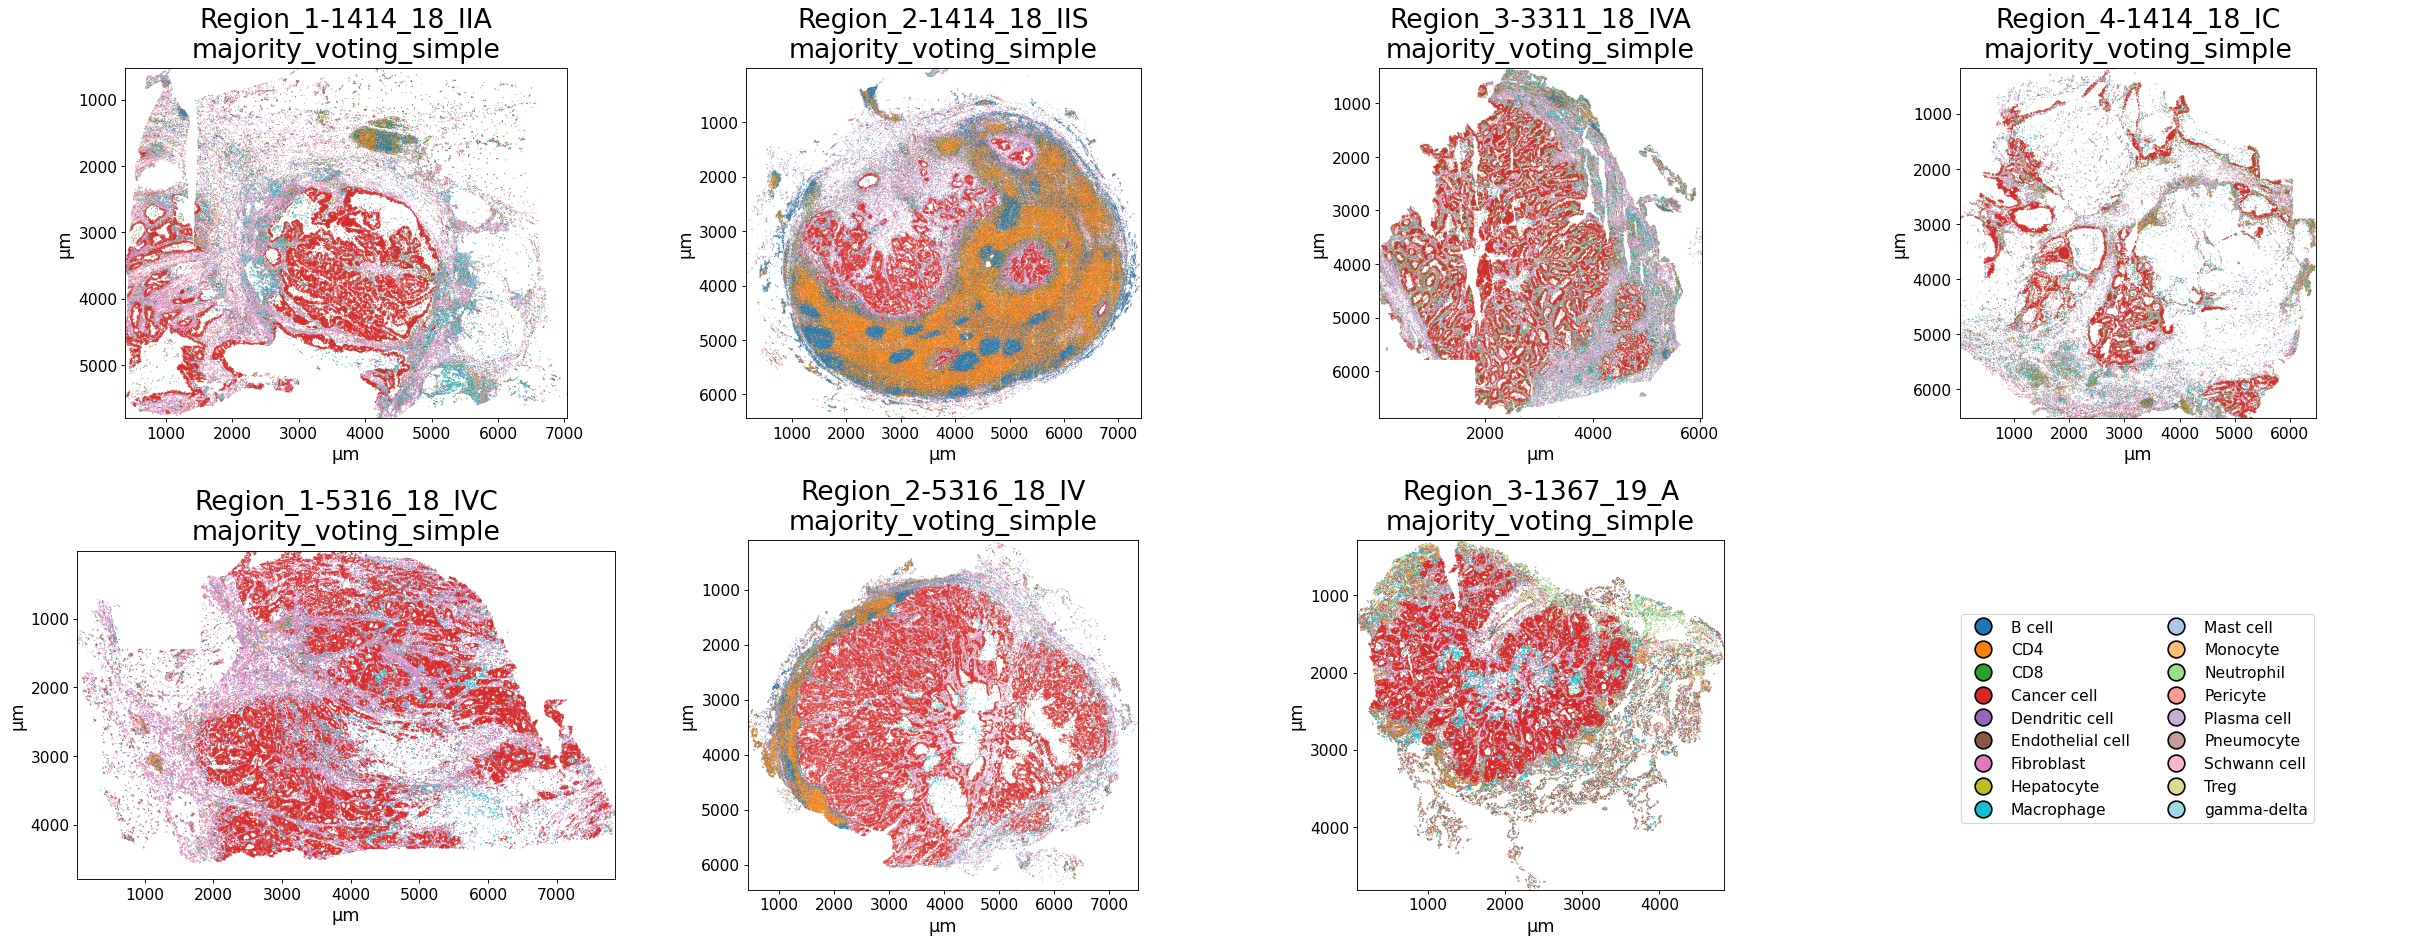

In [12]:
plot_spatial(exp, cells_layer="proseg",
             keys="majority_voting_simple", spot_size=12,
             #savepath="figures/spatial-all-majority_voting_simple.png"
             )

## Analyze composition of annotations

In [14]:
from insitupy.plotting import plot_cellular_composition
import numpy as np

Re-assign the cells to the new annotations.

In [15]:
for meta, xd in exp.iterdata():
    xd.assign_annotations()

Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Added results to `.cells['proseg'].matrix.obsm['annotations']
Using CellData from MultiCellData layer 'proseg'.
Assigning key 'Tanja'...


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Added results to `.cells['proseg'].matrix.obsm['annotations']


Saving figure to file figures/cellcomp-all_datasets-annotations_selected.pdf
Saved.


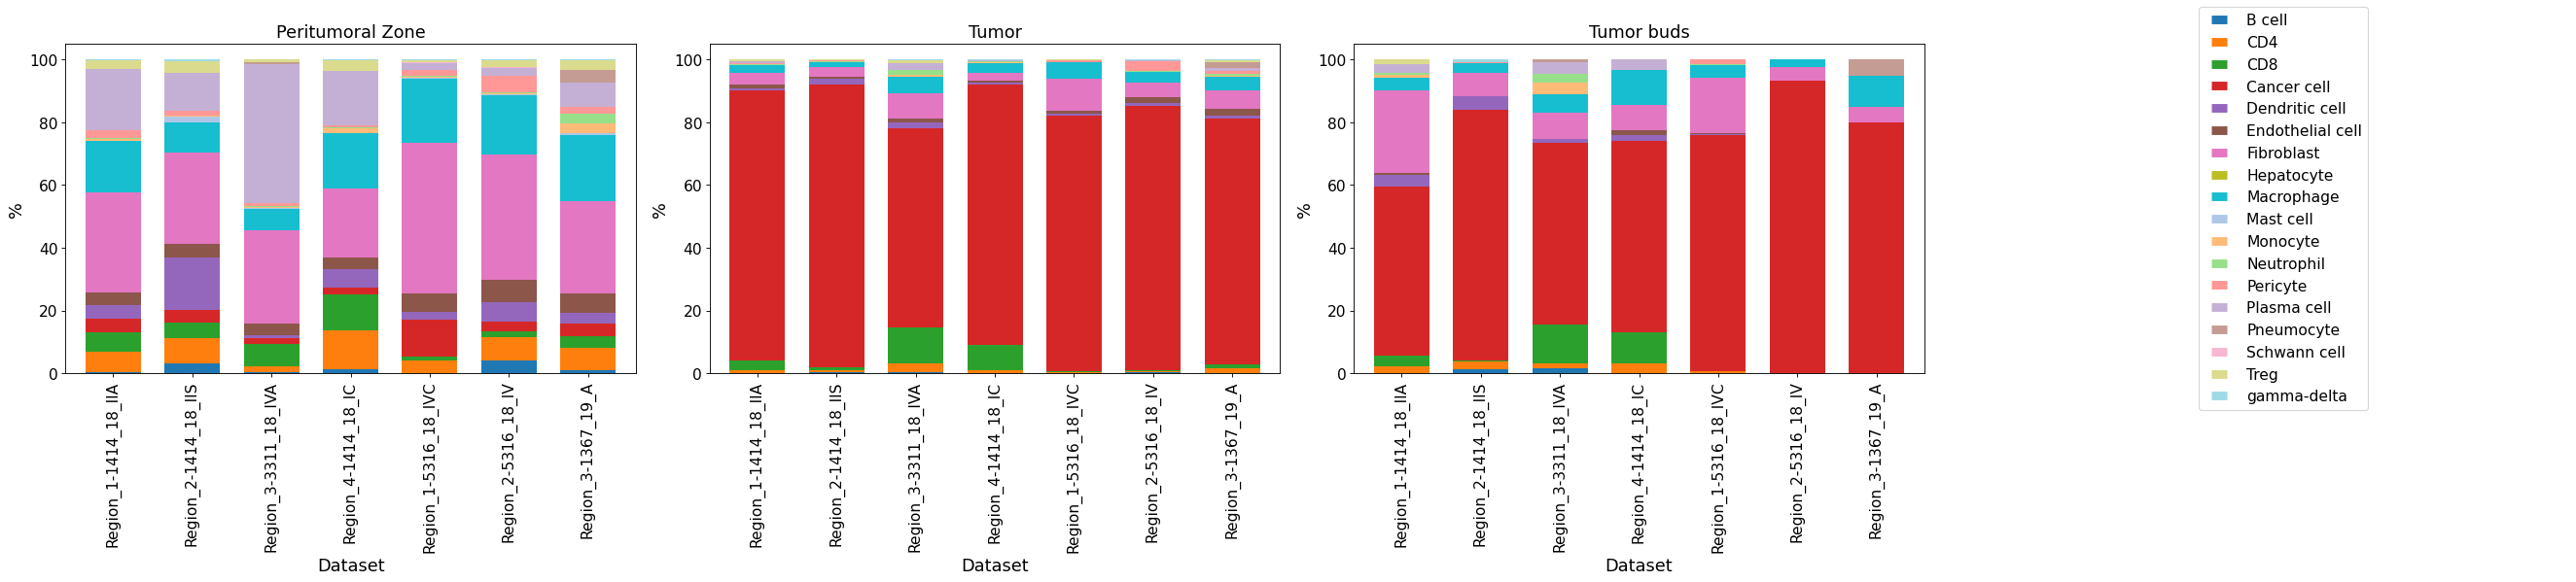

In [16]:
#cell_types = xd.cells.matrix.obs["cell_type"]
plot_cellular_composition(
    data=exp,
    cell_type_col="majority_voting_simple",
    cells_layer="proseg",
    geom_key="Tanja",
    geom_values=["Peritumoral Zone", "Tumor", "Tumor buds"],
    modality="annotations",
    plot_type="bar",
    aspect_factor=0.9,
    savepath="figures/cellcomp-all_datasets-annotations_selected.pdf"
)

Show only the composition of the cancer cells.

In [17]:
for meta, xd in exp.iterdata():
    xd.cells["proseg"].matrix.obs["cancer_mask"] = xd.cells["proseg"].matrix.obs["cell_type"].str.contains("Cancer cell")

Saving figure to file figures/cellcomp-all_datasets-cancer_subtypes.pdf
Saved.


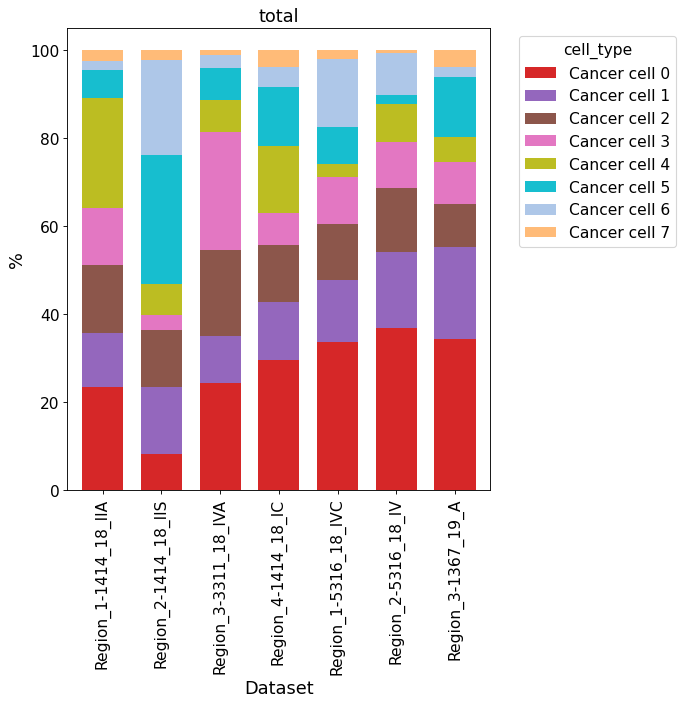

In [18]:
cell_types = xd.cells.matrix.obs["cell_type"]
selected_cell_types = np.unique(cell_types[cell_types.str.contains("Cancer cell")])
plot_cellular_composition(
    data=exp,
    cell_type_col="cell_type",
    cell_type_values=selected_cell_types,
    cells_layer="proseg",
    mask_col="cancer_mask",
    plot_type="bar",
    aspect_factor=1.1,
    savepath="figures/cellcomp-all_datasets-cancer_subtypes.pdf"
)

Saving figure to file figures/cellcomp-all_datasets-annotations_Tumor_buds.pdf
Saved.


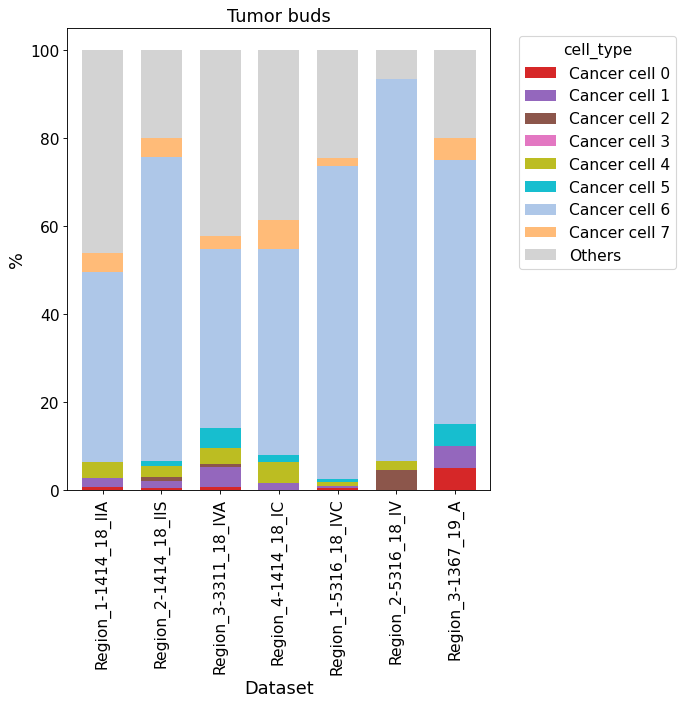

In [19]:
import numpy as np
selected_cats = ["Tumor buds"]
cell_types = xd.cells.matrix.obs["cell_type"]
selected_cell_types = np.unique(cell_types[cell_types.str.contains("Cancer cell")])
plot_cellular_composition(
    data=exp,
    cell_type_col="cell_type",
    cell_type_values=selected_cell_types,
    cells_layer="proseg",
    geom_key="Tanja", geom_values=selected_cats,
    modality="annotations", #max_cols=3,
    plot_type="bar",
    aspect_factor=1.1,
    savepath="figures/cellcomp-all_datasets-annotations_Tumor_buds.pdf"
)

Saving figure to file figures/cellcomp-all_datasets-annotations_Tumor_buds_cancer.pdf
Saved.


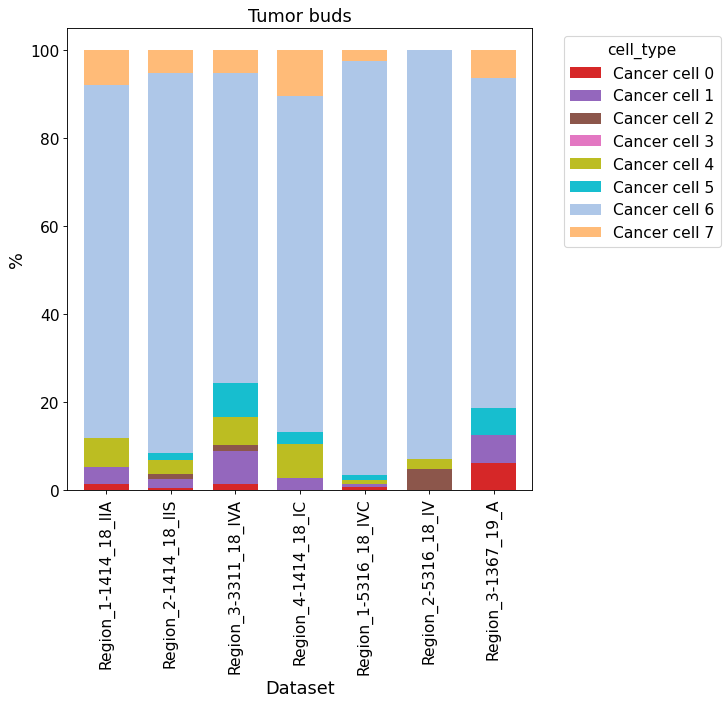

In [20]:
import numpy as np
selected_cats = ["Tumor buds"]
#cell_types = xd.cells.matrix.obs["cell_type"]
#selected_cell_types = np.unique(cell_types[cell_types.str.contains("Cancer cell")])
plot_cellular_composition(
    data=exp,
    cell_type_col="cell_type",
    #cell_type_values=selected_cell_types,
    cells_layer="proseg",
    geom_key="Tanja", geom_values=selected_cats,
    modality="annotations", #max_cols=3,
    mask_col="cancer_mask",
    plot_type="bar",
    savepath="figures/cellcomp-all_datasets-annotations_Tumor_buds_cancer.pdf"
)

## Check location of tumor buds

Collect data from anndata objects of all samples using `collect_anndatas`. Only the data that is required in the next steps is collected to save memory.

In [21]:
adata = exp.collect_anndatas(
    cells_layer="proseg", label_col="sample_id",
    obs_keys=["majority_voting_simple", "cell_type"],
    obsm_keys=["X_umap_scanvi", "annotations"],
    uns_keys='cell_type_colors'

    )

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After concatenation of the `AnnData` some of the `obs_names` can be duplicated. Here we make them unique again.

In [22]:
adata.obs_names_make_unique()

In [23]:
cancer = adata[adata.obs["cell_type"].str.contains("Cancer cell")].copy()

In [24]:
adata.obs["in_tumor_bud"] = adata.obsm["annotations"]["Tanja"].str.contains("Tumor buds")
cancer.obs["in_tumor_bud"] = cancer.obsm["annotations"]["Tanja"].str.contains("Tumor buds")

The UMAP plot has to be plotted separately for each category to make sure that all "True" values are in the foreground and not covered by false values.

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


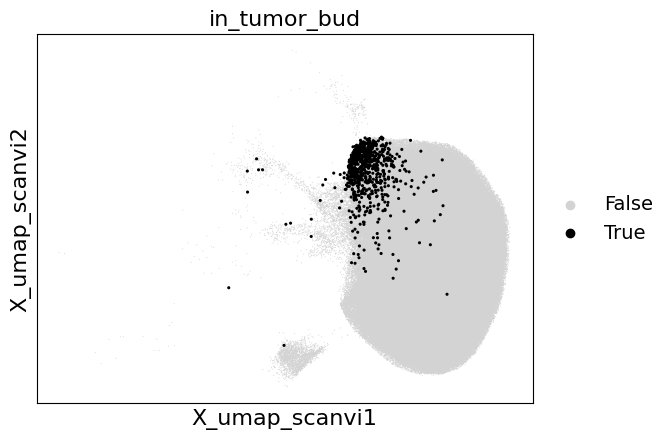

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

sc.pl.embedding(
    cancer[~cancer.obs["in_tumor_bud"]],
    basis="X_umap_scanvi", color="in_tumor_bud",
    s=2,
    palette=["lightgray"],
    show=False,
    ax=ax
)

sc.pl.embedding(
    cancer[cancer.obs["in_tumor_bud"]],
    basis="X_umap_scanvi",
    color="in_tumor_bud",
    s=20,
    palette=["black"],
    show=False,
    ax=ax
)

plt.savefig("figures/X_umap_scanvi_tumor_buds.png", dpi=600)
plt.show()

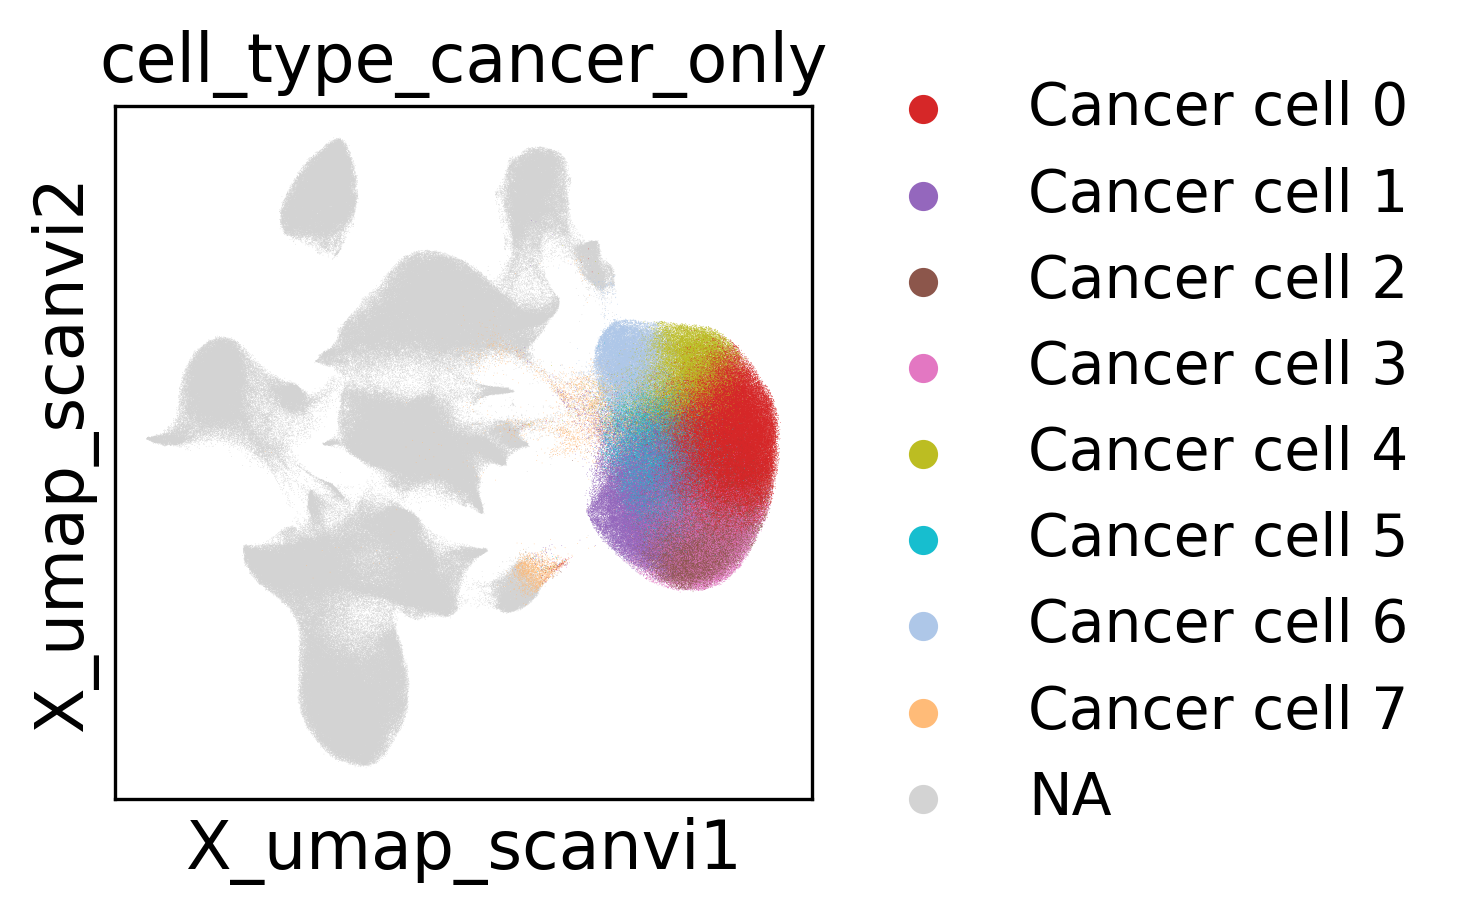

In [26]:
adata.obs["cell_type_cancer_only"] = [elem if "Cancer cell" in elem else np.nan for elem in adata.obs["cell_type"]]

with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.embedding(
        adata,
        basis="X_umap_scanvi",
        color="cell_type_cancer_only",
        palette=exp.colors["cell_type"],
        #save="_cancer_cell_subclusters_05.png"
    )

Cells in tumor buds match with Cancer cell subtype 6.

### Save results

In [27]:
exp.save()

100%|██████████| 7/7 [00:53<00:00,  7.62s/it]
